# Coding Discussion 05
## Charlie Zhang

**Can we predict whether someone will vote or not?**

In the discussion folder, you'll find the `turnout.csv` data, which was drawn from the 2012 National Election Survey. The data records the age, eduction level (of total years in school), income, race (caucasian or not), and past voting record (i.e. whether or not the respondent voted in the 2012 Presidential election). The sample is composed of 2000 individual respondents. 

Please break the data up into a training (1600 entries, 80%) and test dataset (400 entries, 20%). 

Build a Naive Bayesian Classifier from scratch that tries to predict whether a respondent will vote in a presidential election or not, pr(Vote==1). The classifier must be built from scratch. Do not use a third party ML or statistical package. 

Run your algorithm and see how it predicts on the test data. Use the `sklearn.metrics` library to calculate the predictive accuracy and the area underneath the ROC curve. 

Does your model perform better than chance (i.e. coin flip)?

When completing this answer, be sure to: 

- comment on all your code
- provide a narrative for what you're doing
- summarize your results and findings


In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st # for Normal PDF

## Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import pprint as pp
from plotnine import *

## Silence warnings 
import warnings
warnings.filterwarnings("ignore")

from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

In [2]:
## Read the data
turnout= pd.read_csv('../turnout.csv')

## Display the data
turnout.head(5)

,id,age,educate,income,vote,white
0,1,60,14.0,3.3458,1,1
1,2,51,10.0,1.8561,0,1
2,3,24,12.0,0.6304,0,1
3,4,38,8.0,3.4183,1,1
4,5,25,12.0,2.7852,1,1


In [3]:
## Train-test split
train= turnout.sample(frac=.8).reset_index(drop=True)
test= turnout.sample(frac=.2).reset_index(drop= True)

## Show the shape of training and testing dataset
print(train.shape[0], test.shape[0])

## Display the head of training dataset
train.head(5)

1600 400


,id,age,educate,income,vote,white
0,1961,63,12.0,1.1277,1,1
1,243,71,10.0,0.8236,1,0
2,230,29,19.0,2.1885,1,1
3,1593,47,12.0,14.9247,1,1
4,195,32,19.0,7.5945,1,1


### Calculate Class Probability $Pr(class)$

In [4]:
N= train.shape[0]

## Subset the data by voting 
vt1= train.query("vote== 1")
vt0= train.query("vote== 0")

## Calculate the probability of each class
pr_vt1= vt1.shape[0]/N
pr_vt0= vt0.shape[0]/N

## Print the probabilities
print(
f"""
Pr(vote = 1): {pr_vt1}
Pr(vote = 0): {pr_vt0}
""")


Pr(vote = 1): 0.75
Pr(vote = 0): 0.25



### Conditional Probabilities for Race $Pr(data|class)$ 
The race, being Caucasian or not, is the only binary variable, and then we have: 
- $Pr(white = 1 | vote = 1)$
- $Pr(white = 0 | vote = 1)$
- $Pr(white = 1 | vote = 0)$
- $Pr(white = 0 | vote = 0)$

In [5]:
## Given vote == 1
w1_vt1= vt1.query("white == 1").shape[0]/vt1.shape[0]
w0_vt1= vt1.query("white == 0").shape[0]/vt1.shape[0]

## Given vote == 0
w1_vt0= vt0.query("white == 1").shape[0]/vt0.shape[0]
w0_vt0= vt0.query("white == 0").shape[0]/vt0.shape[0]

print(
f"""
Pr(white = 1 | vote = 1): {w1_vt1}
Pr(white = 0 | vote = 1): {w0_vt1}
Pr(white = 1 | vote = 0): {w1_vt0}
Pr(white = 0 | vote = 0): {w0_vt0}
""")


Pr(white = 1 | vote = 1): 0.8833333333333333
Pr(white = 0 | vote = 1): 0.11666666666666667
Pr(white = 1 | vote = 0): 0.785
Pr(white = 0 | vote = 0): 0.215



### Continuous Variables

In [6]:
## Collect the mean and standard deviation of each conditional distribution
dist_locs= \
{("age", 1):{'mean':vt1.age.mean(),'sd':vt1.age.std()},
 ("age", 0):{'mean':vt0.age.mean(),'sd':vt0.age.std()},
 ("educate",1):{'mean':vt1.educate.mean(),'sd':vt1.educate.std()},
 ("educate",0):{'mean':vt0.educate.mean(),'sd':vt0.educate.std()},
 ("income",1):{'mean':vt1.income.mean(),'sd':vt1.income.std()},
 ("income",0):{'mean':vt0.income.mean(),'sd':vt0.income.std()},    
}

pp.pprint(dist_locs)

{('age', 0): {'mean': 42.0375, 'sd': 18.76997265404465},
 ('age', 1): {'mean': 46.138333333333335, 'sd': 16.947769360424214},
 ('educate', 0): {'mean': 10.83875, 'sd': 3.2781838968633483},
 ('educate', 1): {'mean': 12.592083333333333, 'sd': 3.261417334367527},
 ('income', 0): {'mean': 2.845742, 'sd': 2.249986234106817},
 ('income', 1): {'mean': 4.2850305, 'sd': 2.9336910318365725}}


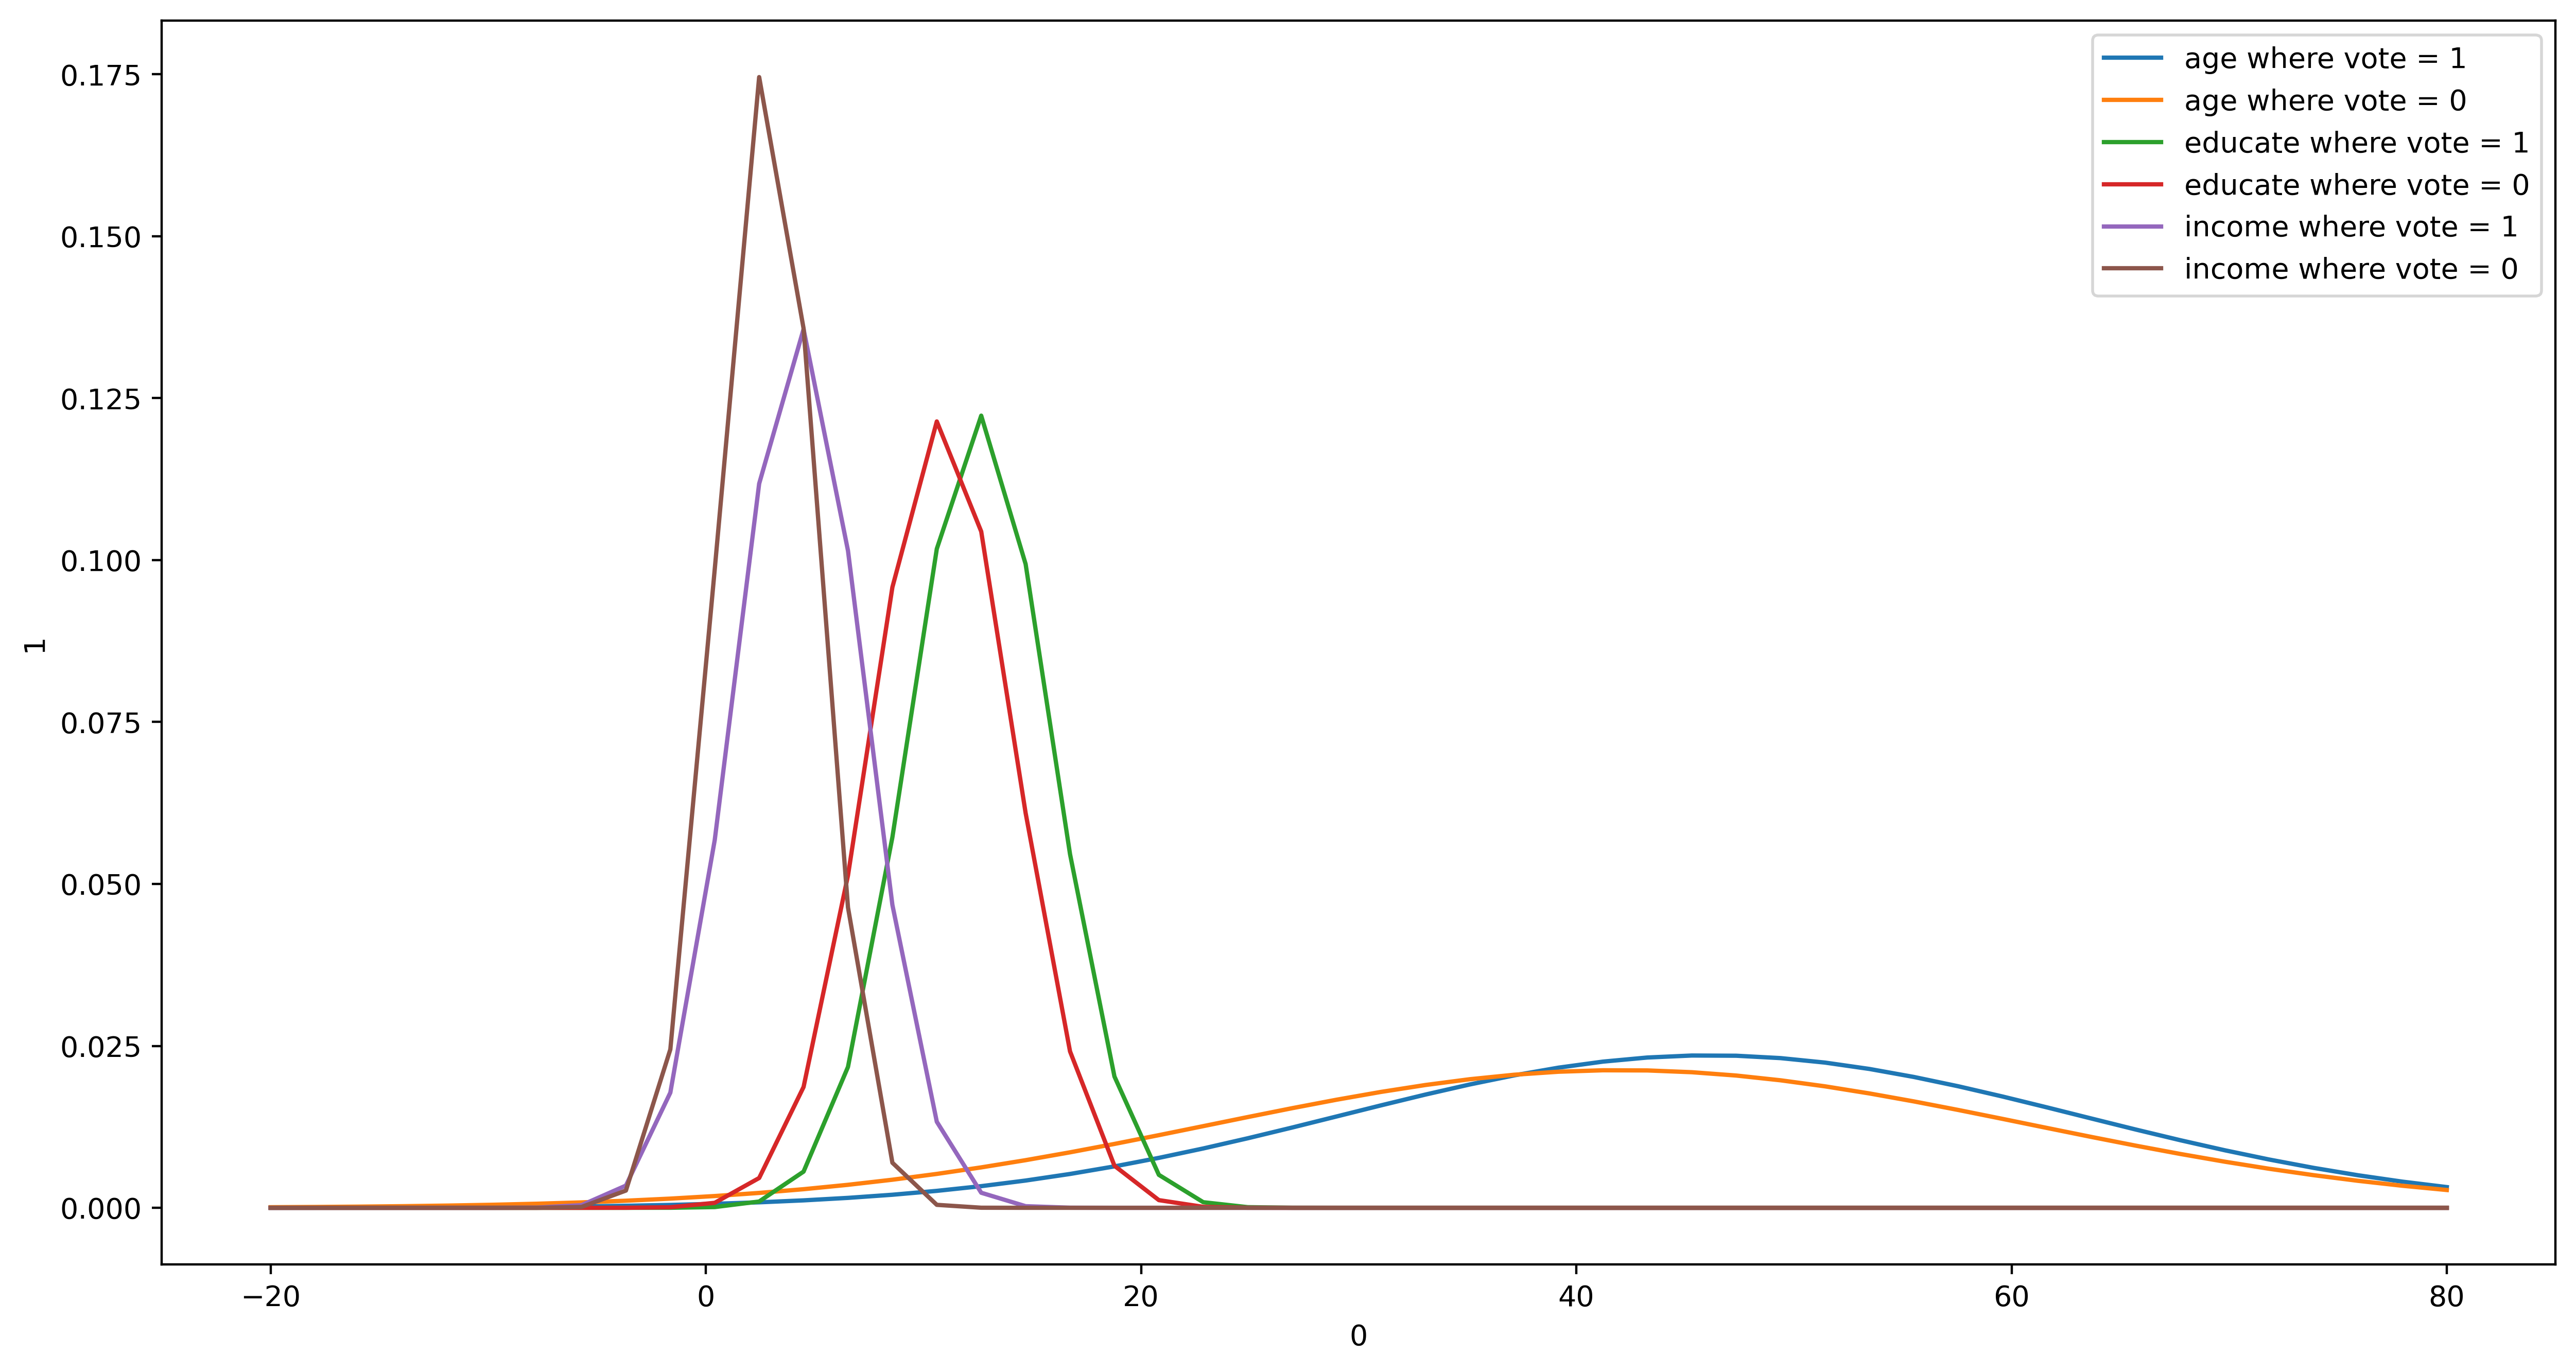

In [7]:
# Plot the pdf by seaborn
plt.figure(figsize=(15,8), dpi=400)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-20,80)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where vote = {key[1]}")

### Prediction
Supporsing $X$ are $I.I.D$:
$$Pr(X | \omega_j ) = Pr( x_1| \omega_j)\times Pr( x_2| \omega_j) \times \dots \times  Pr(\omega_j)= 	\prod_{k = 1}^{d} Pr( x_k| \omega_j)$$
Continous variables follow the Gaussian distribution, and the binary variable mostly follows the Bernoulli distribution. However, in naive Bayes, mixing variable seems not a big problem, and we have: 
$$ Pr(X | \omega_j ) = Pr(X_{Bernoulli} | \omega_j ) \times Pr(X_{Gaussian} | \omega_j ) $$

In [8]:
def predict(data, dist_locs, binary= None, binary_probs= None):
    '''
    This function predicts the outcome by using the training data.
    
    Inputs:
    data - The dataframe for training data. 
    dist_locs - The dictinonary that includes the mean and standard deviation of continous variables. 
    binary- The default is None, and it can be a list of variable name whenever there is a binary variable.
    binary_probs- The binary probability dataset that follows the Bernoulli distribution. 

    '''
    store_preds = []
    for i,row in data.iterrows():
        
        ## Set the initial probability to 0 and 1
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            
            ## Exclude the outcome varaible
            if row.index[j] != "vote":
                ## If there is a binary variable, then search the particular value prepared for multiplication
                if row.index[j] in binary:
                    pr_0*= binary_probs[(row.index[j],row.values[j],0)]
                    pr_1*= binary_probs[(row.index[j],row.values[j],1)] 
                else: 
                    pr_0*= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                    pr_1*= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                                dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_vt0
        pr_1 *= pr_vt1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

In [9]:
## Set up the binary variable probabilities
white_probs = \
{('white', 1, 1): w1_vt1,
 ('white', 0, 1): w0_vt1,
 ('white', 1, 0): w1_vt0,
 ('white', 0, 0): w0_vt0
}

In [10]:
## Display the head of prediction
preds_train = predict(train,dist_locs, binary= ["white"], binary_probs= white_probs)
preds_train.sample(10)

,pr_0,pr_1,pred
1514,4.430228e-05,0.000100,1
28,6.821929e-06,0.000009,1
744,4.946869e-08,0.000014,1
334,9.636541e-07,0.000045,1
1422,4.142087e-05,0.000224,1
591,4.227201e-06,0.000005,1
1347,3.996645e-05,0.000066,1
450,2.307236e-05,0.000028,1
1286,4.716713e-05,0.000147,1
164,4.699188e-05,0.000099,1


In [11]:
## Examine the predictive accuracy on training dataset
accuracy_train= sum(train.vote== preds_train.pred)/train.shape[0]

## Examine the predictive accuracy on testing dataset
preds_test= predict(test,dist_locs, binary= ["white"], binary_probs= white_probs)
accuracy_test= sum(test.vote== preds_test.pred)/test.shape[0]

print(
    f"""
Predictive accuracy on Training: {accuracy_train}
Predictive accuracy on Testing: {accuracy_test}
""")


Predictive accuracy on Training: 0.745625
Predictive accuracy on Testing: 0.725



## `sklearn` implementation

In [13]:
# Organize our data to plug into the sklearn
train_y= train['vote']
train_x= train[['age','educate','income']]
test_y= test['vote']
test_x= test[['age','educate','income']]

In [14]:
# Instantiate the model class
gnb= GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred= gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.74

We got a medicore accuracy score 0.74, implying that 74% of our prediction derived from the training dataset actually fit the testing dataset. 

In [15]:
m.roc_auc_score(test_y,y_pred)

0.5586013382257716

The area under the curve is 0.559, suggesting that the model is not very precise. 

In [16]:
probs= gnb.predict_proba(test_x)
probs= pd.DataFrame(probs,columns=gnb.classes_)
probs.head()

,0,1
0,0.238146,0.761854
1,0.274383,0.725617
2,0.262583,0.737417
3,0.428432,0.571568
4,0.323754,0.676246


In [17]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

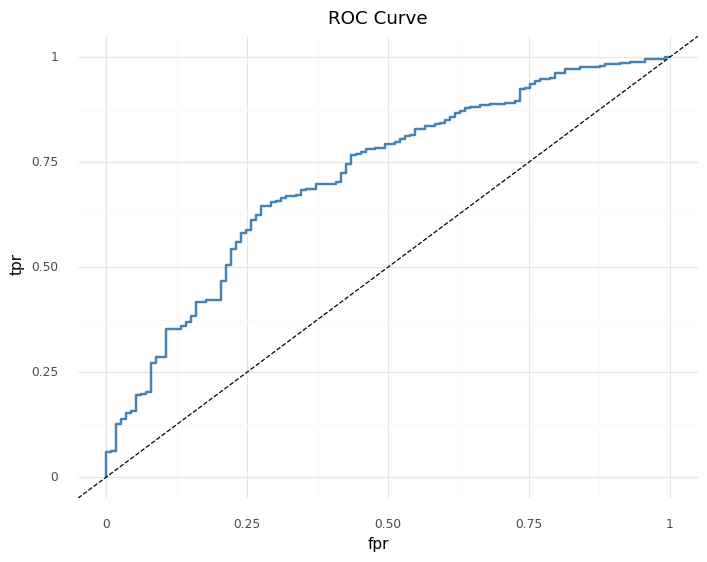

<ggplot: (8774080265201)>

In [18]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(8,6))
)

### Discussion

When the false posite rate is below 0.25, the true positive rate rapidly increases below as false positive rate increases. However, that speed slows down after fpr is greater than 0.25. AUC under the ROC curve is 0.554, suggesting the __prediction is only slightly better than no skills (random)__, which is disappointing. Basically, the model tells that naive Bayes classfier oversimplifies the dynamics of real world as it a) presumes the independence of each variables which are often not the case, e.g. education and income and b) treats different variables with the same weighting, e.g. age and education.